In [0]:
 drive.flush_and_unmount()

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/drive/My Drive/Zip/static/train.rar').extractall('/content/drive/My Drive/Zip/static')
print('Static images done')
Archive('/content/drive/My Drive/Zip/test.rar').extractall('/content/drive/My Drive/Zip')
print('test done')
Archive('/content/drive/My Drive/Zip/train.rar').extractall('/content/drive/My Drive/Zip')
print('train done')
Archive('/content/drive/My Drive/Zip/labels.rar').extractall('/content/drive/My Drive/Zip')
print('Labels Done')

#Archive('/content/drive/My Drive/Zip/train.rar').extractall('/content/drive/My Drive')
#print('Parallel to ZIP')

In [9]:
%tensorflow_version 1.15

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf
import traceback

from tqdm import tqdm_notebook
from scipy.spatial.distance import hamming, cosine



In [0]:
print(tf.__version__)

1.15.2


In [0]:
def image_loader(image_path, image_size): 

  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, image_size,cv2.INTER_CUBIC)
  return image


def dataset_preprocessing(dataset_path, labels_file_path, image_size, image_paths_pickle):

  with open(labels_file_path, "r") as f:
    classes = f.read().split("\n")[:-1]

  images = []
  labels = []
  image_paths = []

  for image_name in os.listdir(dataset_path):
    try:
      image_path = os.path.join(dataset_path, image_name)
      images.append(image_loader(image_path, image_size))
      image_paths.append(image_path)
      
      for idx in range(len(classes)):
          if classes[idx] in image_name:
              labels.append(idx)

    except:
        pass

  with open(image_paths_pickle + ".pickle", "wb") as f:
        pickle.dump(image_paths, f) 

  assert len(images) == len(labels)
  return np.array(images), np.array(labels)      




In [0]:
images, labels = dataset_preprocessing("/content/drive/My Drive/Zip/train/", "/content/drive/My Drive/Zip/labels.txt", (32, 32), "training_images_pickle")

In [13]:
images.shape

(50000, 32, 32, 3)

In [0]:
def cosine_distance(training_set_vectors, query_vector, top_n=50):
  distances = []

  for i in range(len(training_set_vectors)):
      distances.append(cosine(training_set_vectors[i], query_vector[0]))

  return np.argsort(distances)[:top_n]    

In [0]:
def hamming_distance(training_set_vectors, query_vector, top_n=50):
  distances = []

  for i in range(len(training_set_vectors)):
      distances.append(hamming(training_set_vectors[i], query_vector[0]))

  return np.argsort(distances)[:top_n]    

In [0]:
def sparse_accuracy(true_labels, predicted_labels):
  assert len(true_labels) == len(predicted_labels)
  correct = 0
  for i in range(len(true_labels)):
      if np.argmax(predicted_labels[i]) == true_labels[i]:
          correct += 1
  
  return correct / len(true_labels)        

In [0]:
def model_inputs(image_size):

  tf.disable_eager_execution()
  inputs = tf.placeholder(dtype=tf.float32, shape=[None, image_size[0], image_size[1], 3], name='images')
  targets = tf.placeholder(dtype=tf.int32, shape=[None], name='targets')
  dropout_rate = tf.placeholder(dtype=tf.float32, name='dropout_rate')

  return inputs, targets, dropout_rate

In [0]:
def conv_block(inputs,
               number_of_filters,
               kernel_size,
               strides=(1, 1),
               padding='SAME',
               activation=tf.nn.relu,
               max_pool=True,
               batch_norm=True):
    
    conv_features = layer = tf.layers.conv2d(inputs=inputs,
                                             filters=number_of_filters,
                                             kernel_size=kernel_size,
                                             strides=strides,
                                             padding=padding,
                                             activation=activation)
    
    if max_pool:
        layer = tf.layers.max_pooling2d(layer,
                                        pool_size=(2, 2),
                                        strides=(2, 2),
                                        padding='SAME')
        
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)

    return layer, conv_features        

In [0]:
def dense_block(inputs,
                units,
                activation=tf.nn.relu,
                dropout_rate=None,
                batch_norm=True):
  
    dense_features = layer = tf.layers.dense(inputs=inputs,
                                             units=units,
                                             activation=activation)
    
    if dropout_rate is not None:
        layer = tf.layers.dropout(layer,
                                  rate=dropout_rate)
        
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)

    return layer, dense_features        

In [0]:
def opt_loss(logits,
             targets,
             learning_rate):
  
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    return loss, optimizer

In [0]:
class ImageSearchModel(object):
    
    def __init__(self, 
                 learning_rate, 
                 image_size, 
                 number_of_classes=10):
        
        
        tf.reset_default_graph()
        
        #model inputs
        self.inputs, self.targets, self.dropout_rate = model_inputs(image_size)
        
        normalized_images = tf.layers.batch_normalization(self.inputs)
        
        #conv_1 block
        conv_block_1, self.conv_1_features = conv_block(inputs=normalized_images, 
                                                        number_of_filters=64, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
 
        #conv_2 block
        conv_block_2, self.conv_2_features = conv_block(inputs=conv_block_1, 
                                                        number_of_filters=128, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
        #conv_3 block
        conv_block_3, self.conv_3_features = conv_block(inputs=conv_block_2, 
                                                        number_of_filters=256, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
        #conv_4 block
        conv_block_4, self.conv_4_features = conv_block(inputs=conv_block_3, 
                                                        number_of_filters=512, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
        #flattening
        flat_layer = tf.layers.flatten(conv_block_4)
        
        #1st dense block
        dense_block_1, dense_1_features = dense_block(inputs=flat_layer, 
                                                       units=128, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #2nd dense block
        dense_block_2, self.dense_2_features = dense_block(inputs=dense_block_1, 
                                                       units=256, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #3rd dense block
        dense_block_3, self.dense_3_features = dense_block(inputs=dense_block_2, 
                                                       units=512, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #4th dense block
        dense_block_4, self.dense_4_features = dense_block(inputs=dense_block_3, 
                                                       units=1024, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #output layer
        logits = tf.layers.dense(inputs=dense_block_4, 
                                 units=number_of_classes, 
                                 activation=None)
        
        self.predictions = tf.nn.softmax(logits)
        
        self.loss, self.optimizer = opt_loss(logits=logits, 
                                             targets=self.targets, 
                                             learning_rate=learning_rate)
      

In [22]:
model = ImageSearchModel(0.001, (32, 32), 10)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.dropout instead.


In [0]:
def train(model,
          epochs,
          drop_rate,
          batch_size,
          data,
          save_dir,
          saver_delta=0.15):
  
    X_train, y_train, X_test, y_test = data
    
    #session
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    #Define saver
    saver = tf.train.Saver()

    best_test_accuracy = 0

    #Training loop
    for epoch in range(epochs):
        train_accuracy = []
        train_loss = []

        for ii in tqdm_notebook(range(len(X_train) // batch_size)):
            start_id = ii * batch_size
            end_id = start_id + batch_size

            X_batch = X_train[start_id:end_id]
            y_batch = y_train[start_id:end_id]

            feed_dict = {model.inputs:X_batch,
                         model.targets:y_batch,
                         model.dropout_rate:drop_rate}
            
            _, t_loss, preds_t = session.run([model.opt, model.loss, model.predictions], feed_dict=feed_dict)

            train_accuracy.append(sparse_accuracy(y_batch, preds_t))
            train_loss.append(t_loss)


        print("Epoch: {}/{}".format(epoch,epochs),
              " | Training accuracy: {}".format(np.mean(train_accuracy)),
              " | Training loss: {}".format(np.mean(train_loss))) 
        
        test_accuracy = []
        for ii in tqdm_notebook(range(len(X_test) // batch_size)):
            start_id = ii * batch_size
            end_id = start_id + batch_size

            X_batch = X_test[start_id:end_id]
            y_batch = y_test[start_id:end_id]

            feed_dict = {model.inputs:X_batch,
                         model.dropout_rate:0.0}
            
            preds_test = session.run(model.predictions, feed_dict=feed_dict)
            test_accuracy.append(sparse_accuracy(y_batch, preds_test))

        print("Test Accuracy: {}".format(np.mean(test_accuracy)))

        #Saving the model
        if np.mean(train_accuracy) > np.mean(test_accuracy):
            if np.abs(np.mean(train_accuracy) - np.mean(test_accuracy)) <= saver_delta:
                if np.mean(test_accuracy) >= best_test_accuracy:
                    best_test_accuracy = np.mean(test_accuracy)
                    saver.save(session, "{}/model_epoch_{}.ckpt".format(save_dir, epoch))

    session.close()                      


In [0]:
#Setting hyperparameters and Training the model
epochs = 20
batch_size = 128
learning_rate = 0.001
number_of_classes = 10
dropout_rate = 0.6
image_size = (32, 32)

In [0]:
X_train, y_train = dataset_preprocessing("/content/drive/My Drive/Zip/train/", "/content/drive/My Drive/Zip/labels.txt", image_size=image_size, image_paths_pickle="train_images_pickle")

In [26]:
X_train.shape

(50000, 32, 32, 3)

In [0]:
X_test, y_test = dataset_preprocessing("/content/drive/My Drive/Zip/test/", "/content/drive/My Drive/Zip/labels.txt", image_size=image_size, image_paths_pickle="test_images_pickle")

In [28]:
X_test.shape

(10000, 32, 32, 3)

In [0]:
#defining the model
model = ImageSearchModel(learning_rate=learning_rate, image_size=image_size)

In [0]:
data = (X_train, y_train, X_test, y_test)

In [0]:
train(model, epochs, dropout_rate, batch_size, data, "/content/drive/My Drive/Zip/saver")

In [0]:
#pip install tqdm
from tqdm import tqdm

In [0]:
def create_training_set_vectors(model,
                                X_train,
                                y_train,
                                batch_size,
                                checkpoint_path,
                                image_size,
                                distance='hamming'):
  

    session = tf.Session()
    session.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    saver.restore(session, checkpoint_path)

    dense_2_features = []
    dense_4_features = []

    for ii in tqdm_notebook(range(len(X_train) // batch_size)):
        start_id = ii * batch_size
        end_id = start_id + batch_size

        X_batch = X_train[start_id:end_id]

        feed_dict = {model.inputs:X_batch, model.dropout_rate:0.0}

        dense_2, dense_4 = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)

        dense_2_features.append(dense_2)
        dense_4_features.append(dense_4)


    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)

    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)

        training_vectors = np.hstack((dense_2_features, dense_4_features))

        with open("hamming_train_vectors_pickle", "wb") as f:
            pickle.dump(training_vectors, f)

    elif distance == "cosine":     
        training_vectors = np.hstack((dense_2_features, dense_4_features))

        with open("cosine_train_vectors_pickle", "wb") as f:
            pickle.dump(training_vectors, f)

In [0]:
model = ImageSearchModel(learning_rate, image_size)

In [34]:
create_training_set_vectors(model, X_train, y_train, batch_size, "/content/drive/My Drive/Zip/saver/model_epoch_5.ckpt", image_size)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Zip/saver/model_epoch_5.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [0]:
def simple_inference(model,
                     session,
                     train_set_vectors,
                     uploaded_image_path,
                     image_size,
                     distance='hamming'):
  
    image = image_loader(uploaded_image_path, image_size)
    
    feed_dict = {model.inputs:[image], model.dropout_rate:0.0}

    dense_2_features, dense_4_features = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)

    closest_ids = None
    if distance == "hamming":
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)

        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))

        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
    elif distance == "cosine":
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))

        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)

    return closest_ids        



In [0]:
#define session and model
model = ImageSearchModel(learning_rate=learning_rate, image_size=image_size)

session = tf.Session()
session.run(tf.global_variables_initializer())

In [37]:
#restore session
saver = tf.train.Saver()
saver.restore(session, "/content/drive/My Drive/Zip/saver/model_epoch_5.ckpt")

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Zip/saver/model_epoch_5.ckpt


In [0]:
#load training set image paths
with open('train_images_pickle.pickle', 'rb') as f:
    train_image_paths = pickle.load(f)

In [39]:
train_image_paths[:10]

['/content/drive/My Drive/Zip/train/0_frog.png',
 '/content/drive/My Drive/Zip/train/10000_automobile.png',
 '/content/drive/My Drive/Zip/train/10001_frog.png',
 '/content/drive/My Drive/Zip/train/10002_frog.png',
 '/content/drive/My Drive/Zip/train/10003_ship.png',
 '/content/drive/My Drive/Zip/train/10004_ship.png',
 '/content/drive/My Drive/Zip/train/10005_cat.png',
 '/content/drive/My Drive/Zip/train/10006_deer.png',
 '/content/drive/My Drive/Zip/train/10007_frog.png',
 '/content/drive/My Drive/Zip/train/10008_airplane.png']

In [0]:
#load training set vectors
with open('hamming_train_vectors_pickle', 'rb') as f:
    train_set_vectors = pickle.load(f)

In [0]:
#testing
test_image = '/content/drive/My Drive/Zip/1_ship.png'

In [0]:
#get closest image ids
result_ids = simple_inference(model, session, train_set_vectors, test_image, image_size, distance='hamming')

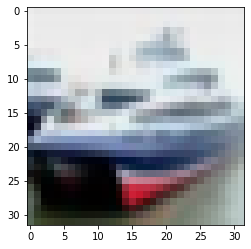

In [120]:
#show query image
plt.imshow(image_loader(test_image, image_size))

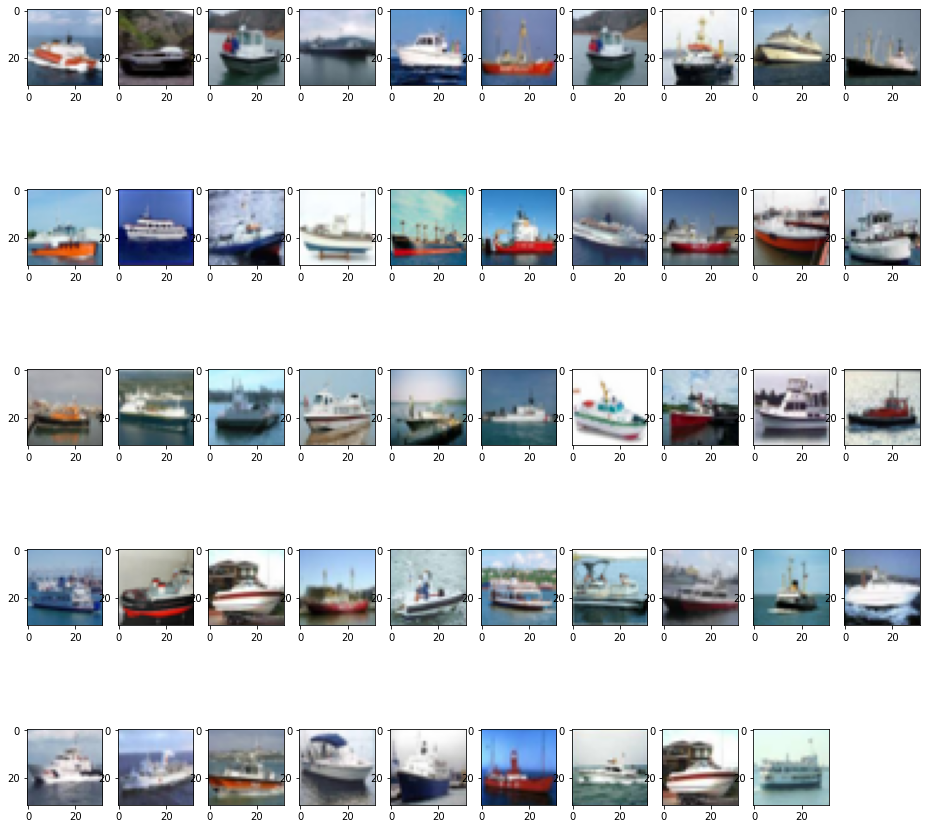

In [121]:
#show result images
w = 10
h = 10
fig = plt.figure(figsize=(16,16))
columns = 10
rows = 5
for i in range(1, columns*rows+1):
    try:
        image = image_loader(train_image_paths[result_ids[i]], image_size)
        fig.add_subplot(rows, columns, i)
        plt.imshow(image)
    except:
        pass
plt.show()            

In [0]:
#import flask dependancy
from flask import Flask, request, render_template, send_from_directory

In [0]:
#setting root directry
#__file__ = "/content/drive/My Drive/Zip"
#APP_ROOT = os.path.dirname(os.path.abspath(__file__))

In [0]:
APP_ROOT = os.path.dirname(os.path.abspath(__file__))

In [0]:
#define model
model = ImageSearchModel(learning_rate=learning_rate, image_size=image_size, number_of_classes=number_of_classes)

In [133]:
#start session
session = tf.Session()
session.run(tf.global_variables_initializer())

#restore session
saver = tf.train.Saver()
saver.restore(session, "/content/drive/My Drive/Zip/saver/model_epoch_5.ckpt")

#load training set vectors
with open('hamming_train_vectors_pickle', 'rb') as f:
    train_vectors = pickle.load(f)

#load training set path
with open('train_images_pickle.pickle', 'rb') as f:
	  train_images_paths = pickle.load(f)


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Zip/saver/model_epoch_5.ckpt


In [0]:
#from flask_ngrok import run_with_ngrok
#from flask import Flask
#app = Flask(__name__)
#run_with_ngrok(app)   #starts ngrok when the app is run
#@app.route("/")
#def home():
#    return render_template("index.html")
  
#app.run()



In [0]:
#defining flask app
#from flask_ngrok import run_with_ngrok
from flask import Flask


app = Flask(__name__, static_url_path='/static')
#run_with_ngrok(app)   #starts ngrok when the app is run
#app.run()


# #defining apps homepage
@app.route("/")
def index():
     return render_template("index.html")
    # return "testing index route"

#@app.route("/")
#def home():
#    return "<h1>Running Flask on Google Colab!</h1>"

In [0]:
#Define upload function
@app.route("/upload", methods=["POST"])
def upload():

	upload_dir = os.path.join(APP_ROOT, "/content/drive/My Drive/Zip/uploads/")

	if not os.path.isdir(upload_dir):
		os.mkdir(upload_dir)

	for img in request.files.getlist("file"):
		img_name = img.filename
		destination = "/".join([upload_dir, img_name])
		img.save(destination)

	#inference
	result = np.array(train_images_paths)[simple_inference(model, session, train_vectors, os.path.join(upload_dir, img_name), image_size)]

	result_final = []

	for img in result:
		result_final.append("train/"+img.split("/")[-1]) #example: dataset/train/0_frog.png -> [dataset, train, 0_frog.png] -> [-1] = 0_frog.png

	return render_template("result.html", image_name=img_name, result_paths=result_final) #added [:-2] just to have equal number of images in the result page per row


In [136]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))


https://y0didovhjrc-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [137]:
#Define helper function for finding image paths
@app.route("/upload/<filename>")
def send_image(filename):
	return send_from_directory("/content/drive/My Drive/Zip/uploads", filename)

#Start the application
if __name__ == "__main__":
	app.run(port=5000)
 

#traceback.print_exc() 

 * Serving Flask app "Zip" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [06/Jun/2020 18:22:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Jun/2020 18:22:53] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [06/Jun/2020 18:23:10] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [06/Jun/2020 18:23:11] "GET /upload/100_deer.png HTTP/1.1" 200 -
127.0.0.1 - - [06/Jun/2020 18:23:11] "GET /static/train/49760_horse.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Jun/2020 18:23:11] "GET /static/train/7835_cat.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Jun/2020 18:23:11] "GET /static/train/16039_horse.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Jun/2020 18:23:11] "GET /static/train/44260_dog.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Jun/2020 18:23:11] "GET /static/train/47514_horse.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Jun/2020 18:23:11] "GET /static/train/46484_horse.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Jun/2020 18:23:11] "GET /static/train/17532_horse.png HTTP/1.1" 404 -
127.0.0.1 - - [06/Jun/2020 18:23:11] "GET /static/tr

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [0]:
@app.route('/')
def hello_world():
   return render_template('index.html') 

if __name__ == '__main__':
    app.run(host='0.0.0.0',port=5000)

In [0]:
#!pip install flask-ngrok

In [0]:
from flask import Flask,render_template
app = Flask(__name__)

@app.route('/')
def hello_world():
   #return render_template('index.html') 
   return "hello"

if __name__ == '__main__':
    app.run(host='0.0.0.0',port=5000)

